In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [24]:
def objective(x):
    return x[0]*x[3]*(x[0]+x[1]+x[2])+x[1]

def constraint1(x):
    return x[0]*x[1]*x[2]*x[3]-25.0

def constraint2(x):
    x_sum=40
    for i in range(4):
        x_sum = x_sum - x[i]**2
    return x_sum

x0 = [1.0,5.0,1.0,5.0]
print(objective(x0))

b=(1.0,5.0)
bnds = (b,b,b,b)
con1 = {'type': 'ineq', 'fun': constraint1}
con2 = {'type': 'eq', 'fun': constraint2}
cons = (con1,con2)

sol = minimize(objective,x0,method = "SLSQP", bounds = bnds, constraints = cons)

print(sol)

print(sol.x)

40.0
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 30.69693845669923
       x: [ 1.000e+00  5.000e+00  1.449e+00  3.449e+00]
     nit: 5
     jac: [ 2.915e+01  4.449e+00  3.449e+00  7.449e+00]
    nfev: 26
    njev: 5
[1.         5.         1.44948974 3.44948974]


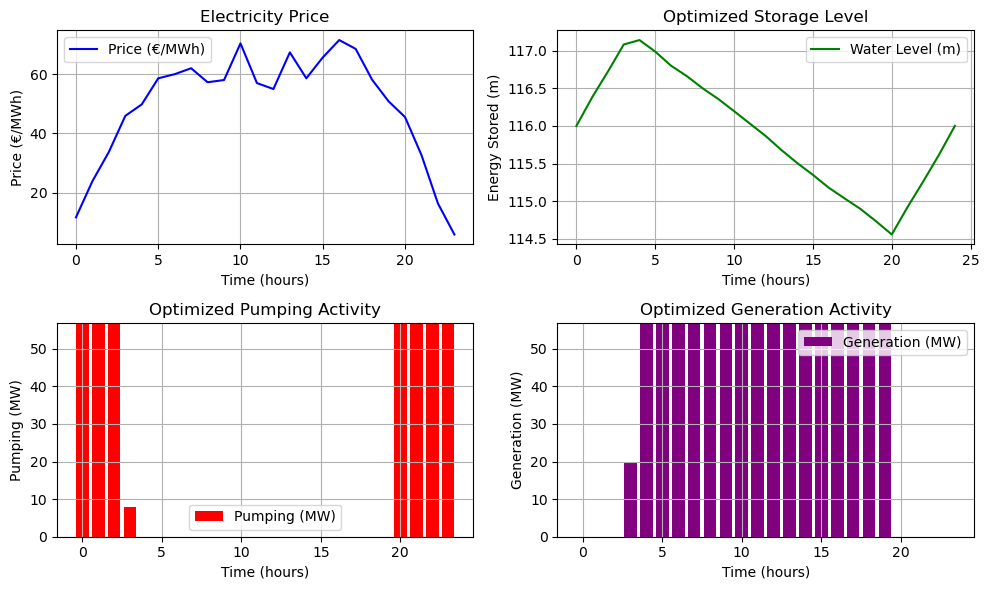

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -46064.471920071934
       x: [ 5.690e+01  5.690e+01 ...  3.041e-09  2.697e-09]
     nit: 20
     jac: [ 1.160e+01  2.383e+01 ... -1.629e+01 -5.806e+00]
    nfev: 804
    njev: 16
Total Daily Profit: € 46064.47


In [27]:
#Time horizon (e.g., 24 hours)
T = 24

#generate a stochastic daily energy price
prices = generate_energy_prices(T, base_price=50, peak_amplitudes=[15,20], peak_times=[8, 18], std_dev=5)

# System parameters
rho = 1000                  # Density of water (kg/m^3)
g = 9.81                    # Gravitational Acceleration (m/s^2)
Head = 20                   # Head at full capacity (m)
Area = 1e6                # Surface Area of Lake (m^2) -> assumtption of "Cylindrical" Lake
max_depth = 40              # Maximum Pumping/Turbining Depth (m)
initial_depth = 38            
Q_max = 100  #m^3/s

volume = Area * max_depth    #Working volume in m^3

max_capacity = volume * rho * g * (Head + max_depth) * 1e-9  # Energy Inside full reservoir (MWh)

initial_capacity = volume * rho * g * (Head + initial_depth) * 1e-9   # Energy Inside full reservoir (MWh)

min_capcaity = volume * rho * g * Head  * 1e-9

P_max = Q_max * rho * g * (Head + initial_depth)  * 1e-6

# System parameters
reservoir_capacity = max_capacity   # Maximum storage in MWh
initial_storage = initial_capacity       # Initial storage level (MWh)
S_min = min_capcaity                 # Minimum storage level (MWh)
pump_max = P_max              # Max pumping power (MW)
gen_max = P_max               # Max generation power (MW)

pump_efficiency = 0.9       # Pumping efficiency
gen_efficiency = 0.9        # Generation efficiency

# The decision variables are:
#   p[0], p[1], ..., p[T-1]   (pumping amounts at each time step)
#   g[0], g[1], ..., g[T-1]   (generation amounts at each time step)
# They are stored in a vector z of length 2*T.
# We want:
#   0 <= p[t] <= pump_max  and  0 <= g[t] <= gen_max for all t

# Objective: maximize profit = sum_t [price[t]*(g[t] - p[t])]
# Since minimize() minimizes, we use the negative profit.
def objective(z):
    p = z[:T]
    g = z[T:]
    return -np.sum(prices * (g - p))
    
# Generate stochastic  inflows in MWh per timestep
inflows = stochastic_basin_inflow(T, base_inflow=20, base_std=3, avg_extra=20, rain_prob=0.03, extra_std=5)

# Compute storage trajectory based on decisions z
def compute_storage(z):
    p = z[:T]
    g = z[T:]    
    S = [initial_storage]  
    for t in range(T):
        S.append(S[-1] + pump_efficiency * p[t] - gen_efficiency * g[t] + inflows[t])
        
    return np.array(S)

def compute_head(S):
    """Computes the head (h) based on storage values S."""
    return S / (rho * g * Head * 1e-3)  



# Define constraints: storage limits and cyclic operation 
constraints = []

# 1. For each time step t=1,...,T, storage must be between 0 and reservoir_capacity.
for t in range(1, T+1):
   # Lower bound: S[t] >= S_min  --> S[t] - S_min >= 0
    constraints.append({
        'type': 'ineq',
        'fun': lambda z, t=t: compute_storage(z)[t] - S_min
    })
    # Upper bound: reservoir_capacity - S[t] >= 0  --> S[t] <= reservoir_capacity
    constraints.append({
        'type': 'ineq',
        'fun': lambda z, t=t: reservoir_capacity - compute_storage(z)[t]
    })

constraints.append({
    'type': 'ineq',
    'fun': lambda z: compute_storage(z)[-1] -  initial_storage  # S[T] >= 90% of initial storage
})

constraints.append({
    'type': 'ineq',
    'fun': lambda z: initial_storage - compute_storage(z)[-1]  # S[T] <= 110% of initial storage
})


# Bounds for decision variables:
# p in [0, pump_max] for t=0,...,T-1 and g in [0, gen_max] for t=0,...,T-1.
bounds = [(0, pump_max)] * T + [(0, gen_max)] * T

# Initial guess: zeros for all decisions
z0 = np.zeros(2 * T)

# Solve the optimization problem using SLSQP(Sequential quadratic programming)
result = minimize(objective, z0, method='SLSQP', bounds=bounds, constraints=constraints)

if result.success:
    z_opt = result.x
    p_opt = z_opt[:T]
    g_opt = z_opt[T:]
    S_opt = compute_storage(z_opt)
    h_opt = compute_head(S_opt)
    total_profit = -objective(z_opt)
    

else:
    print("Optimization did not converge.")
    
# Create a time vector for plotting
time = np.arange(T)

# Plot price series
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.plot(time, prices, label="Price (€/MWh)", color='b',  linestyle='-')
plt.xlabel("Time (hours)")
plt.ylabel("Price (€/MWh)")
plt.title("Electricity Price")
plt.grid(True)
plt.legend()

# Plot optimized storage levels
plt.subplot(2, 2, 2)
plt.plot(np.arange(T+1), h_opt, label="Water Level (m)", color='g', linestyle='-')
#plt.bar(time, inflow, label="Inflow (m)", color='blue', alpha=0.5)
plt.xlabel("Time (hours)")
plt.ylabel("Energy Stored (m)")
plt.title("Optimized Storage Level")
plt.grid(True)
plt.legend()

# Plot optimized pumping decisions
plt.subplot(2, 2, 3)
plt.bar(time, p_opt, label="Pumping (MW)", color='r')
plt.xlabel("Time (hours)")
plt.ylabel("Pumping (MW)")
plt.title("Optimized Pumping Activity")
plt.ylim(0,pump_max)
plt.grid(True)
plt.legend()

# Plot optimized generation decisions
plt.subplot(2, 2, 4)
plt.bar(time, g_opt, label="Generation (MW)", color='purple')
plt.xlabel("Time (hours)")
plt.ylabel("Generation (MW)")
plt.title("Optimized Generation Activity")
plt.ylim(0,gen_max)
plt.grid(True)
plt.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

print(result)
print("Total Daily Profit: €", round(total_profit, 2))

In [ ]:
def conversion_factor(A, rho=1000, g=9.81):
    """
    Computes conversion factor from energy (MWh) to water depth (m).
    1 MWh = 3.6e9 Joules, so:
    k = (3.6e9 J/MWh) / (rho*g*A)  [m/MWh]
    """
    return 3.6e9 / (rho * g * A)

k = conversion_factor(1e6)

water_depth = S_opt * k
inflow_depth = inflows * k

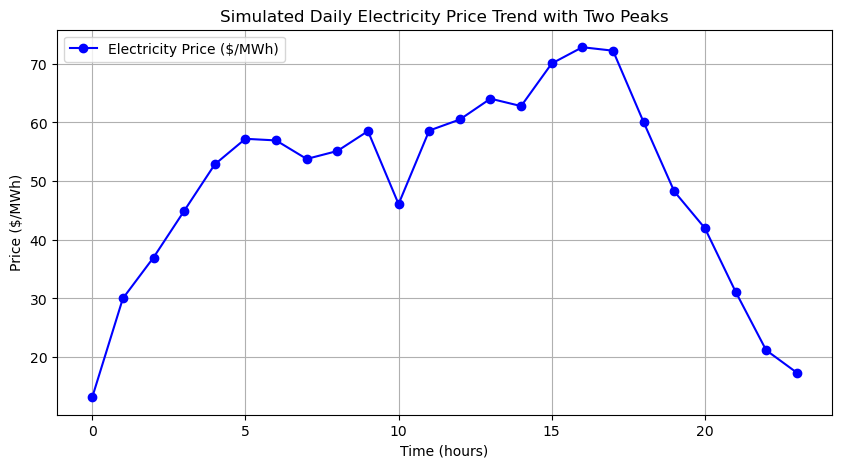

In [5]:
def generate_energy_prices(T, base_price=50, peak_amplitudes=[15,20], peak_times=[8, 18], std_dev=5):
    """
    Generate a realistic daily electricity price trend with two peaks and stochastic variations.

    Parameters:
        T (int): Number of time steps (e.g., hours).
        base_price (float): Average electricity price ($/MWh).
        peak_amplitude (float): Amplitude of price fluctuations due to demand.
        peak_times (list): List of peak electricity price hours (e.g., [8, 18] for morning and evening peaks).
        std_dev (float): Standard deviation for stochastic variations.

    Returns:
        np.array: Simulated electricity prices over time.
    """
    time = np.arange(T)
    
    # Sum of two sinusoidal functions for morning and evening peaks
    prices = (base_price 
              + peak_amplitudes[0] * -np.sin((time - peak_times[0]) * np.pi / 6)  
              + peak_amplitudes[1] * -np.sin((time - peak_times[1]) * np.pi / 12)) 
    
    # Add stochastic noise to simulate market fluctuations
    prices += np.random.normal(0, std_dev, T)
    
    # Ensure prices are non-negative
    prices = np.clip(prices, 0, None)
    
    return prices

# Example usage
T = 24  # 24-hour simulation
prices = generate_energy_prices(T)

# Plot the simulated price trend
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(np.arange(T), prices, label="Electricity Price ($/MWh)", color='b', marker='o', linestyle='-')
plt.xlabel("Time (hours)")
plt.ylabel("Price ($/MWh)")
plt.title("Simulated Daily Electricity Price Trend with Two Peaks")
plt.grid(True)
plt.legend()
plt.show()

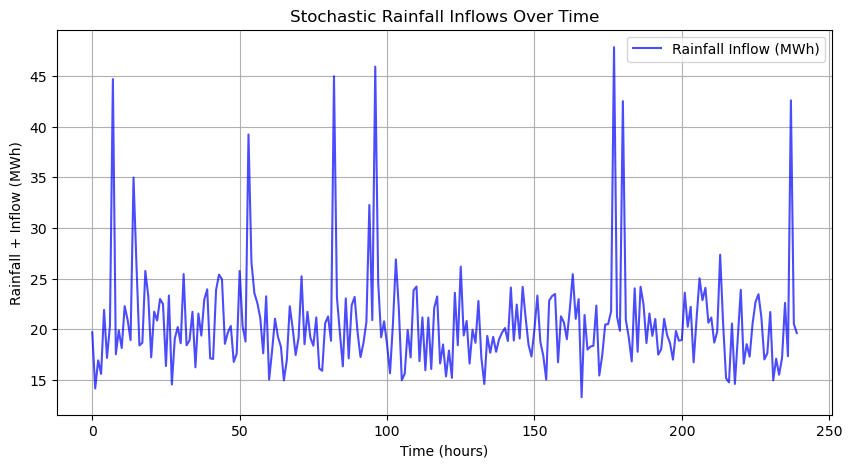

In [7]:
def stochastic_basin_inflow(T, base_inflow=20, base_std=3, avg_extra=20, rain_prob=0.03, extra_std=5):
    """
    Generate stochastic basin inflows over a given time horizon.

    Parameters:
        T (int): Number of time steps (e.g., hours).
        base_inflow (float): Average base inflow (MWh per time step).
        base_std (float): Standard deviation for the base inflow.
        avg_extra (float): Average extra inflow due to rainfall (m³ per time step).
        rain_prob (float): Probability of extra rainfall inflow occurring at each time step.
        extra_std (float): Standard deviation for the extra inflow from rainfall.

    Returns:
        np.array: Stochastic basin inflow series (MWh per time step).
    """
    # Generate the base inflow with its own stochastic variation.
    base = np.random.normal(base_inflow, base_std, T)
    base = np.clip(base, 0, None)  # Ensure non-negative inflow
    
    # Generate extra inflow due to rainfall: binary occurrence * stochastic extra amount.
    rain_events = np.random.binomial(1, rain_prob, T)
    extra = rain_events * np.random.normal(avg_extra, extra_std, T)
    extra = np.clip(extra, 0, None)
    
    # Total inflow is the sum of base and extra rainfall inflows.
    return base + extra
    
# Example usage
T = 240  # 24-hour simulation
rainfall_inflows = stochastic_basin_inflow(T)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(T), rainfall_inflows, color='blue', alpha=0.7, label="Rainfall Inflow (MWh)")
plt.xlabel("Time (hours)")
plt.ylabel("Rainfall + Inflow (MWh)")
plt.title("Stochastic Rainfall Inflows Over Time")
plt.legend()
plt.grid(True)
plt.show()

Efficiency at 75 MW: 0.91


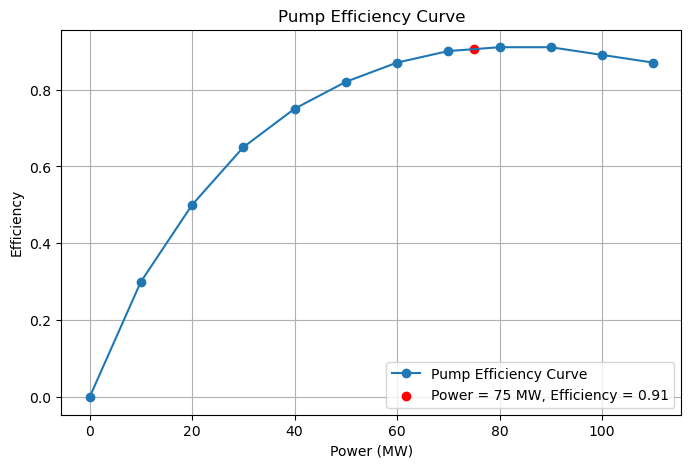

In [161]:
import numpy as np

def pump_efficiency_curve(power):
    """
    Returns the efficiency of a pump based on a fixed efficiency curve for a given power input.
    
    Parameters:
        power (float): The operating power of the pump in MW.
    
    Returns:
        float: Interpolated efficiency at the given power.
    """
    # Hardcoded efficiency curve data
    P = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110])  # Power in MW
    eta = np.array([0, 0.3, 0.5, 0.65, 0.75, 0.82, 0.87, 0.9, 0.91, 0.91, 0.89, 0.87])  # Efficiency
    
    # Interpolate efficiency at given power
    eta_power = np.interp(power, P, eta)
    
    return eta_power

# Example usage
efficiency = pump_efficiency_curve(power=75)
print(f"Efficiency at 75 MW: {efficiency:.2f}")

# Plot efficiency curve for visualization
P = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110])
eta = np.array([0, 0.3, 0.5, 0.65, 0.75, 0.82, 0.87, 0.9, 0.91, 0.91, 0.89, 0.87])
plt.figure(figsize=(8, 5))
plt.plot(P, eta, label='Pump Efficiency Curve', linestyle='-', marker='o')
plt.scatter(75, efficiency, color='red', label=f'Power = 75 MW, Efficiency = {efficiency:.2f}')
plt.xlabel('Power (MW)')
plt.ylabel('Efficiency')
plt.title('Pump Efficiency Curve')
plt.legend()
plt.grid()
plt.show()


366.9724770642202 146.78899082568807 36.69724770642202


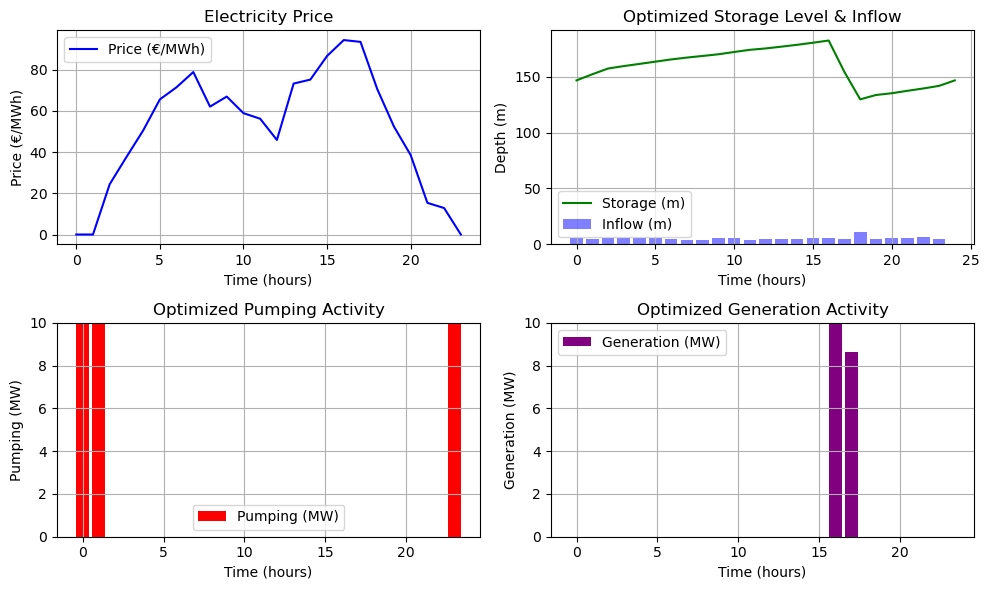

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1750.910903062402
       x: [ 1.000e+01  1.000e+01 ...  2.505e-09  3.172e-09]
     nit: 3
     jac: [-0.000e+00 -0.000e+00 ... -1.284e+01  0.000e+00]
    nfev: 148
    njev: 3
Total Daily Profit: € 1750.91


In [28]:
# Time horizon (e.g., 24 hours)
T = 24

# Generate a stochastic daily energy price (using your dual-peak function)
prices = generate_energy_prices(T, base_price=50, peak_amplitudes=[25,30], peak_times=[8, 18], std_dev=5)

# System parameters
A = 1e6                     # Area of the reservoir (m^2)
reservoir_capacity_MWh = 1000   # Maximum storage in MWh
initial_storage_MWh = 400       # Initial storage level (MWh)
S_min = 100                 # Minimum storage level (MWh)
pump_max = 10              # Max pumping power (MW)
gen_max = 10               # Max generation power (MW)

pump_efficiency = 0.9       # Pumping efficiency
gen_efficiency = 0.9        # Generation efficiency


def conversion_factor(A, rho=1000, g=9.81):
    """
    Computes conversion factor from energy (MWh) to water depth (m).
    1 MWh = 3.6e9 Joules, so:
    k = (3.6e9 J/MWh) / (rho*g*A)  [m/MWh]
    """
    return 3.6e9 / (rho * g * A)

# Compute conversion factor k (m per MWh)
k = conversion_factor(A)

# Convert Storage Amounts into water depth:
max_depth = reservoir_capacity_MWh * k  
initial_depth = initial_storage_MWh * k
minimum_depth = S_min * k

print(max_depth,initial_depth,minimum_depth)

# Generate stochastic basin inflows (in m³ per time step)
inflows = stochastic_basin_inflow(T, base_inflow=5, base_std=1, avg_extra=5, rain_prob=0.03, extra_std=1)

# The decision variables are:
#   p[0], p[1], ..., p[T-1]   (pumping amounts at each time step in MWh)
#   g[0], g[1], ..., g[T-1]   (generation amounts at each time step in MWh)
# Stored in vector z of length 2*T.
# We want:
#   0 <= p[t] <= pump_max  and  0 <= g[t] <= gen_max for all t

# Objective: maximize profit = sum_t [price[t]*(g[t] - p[t])]
# (We use the negative profit for minimization)
def objective(z):
    p = z[:T]
    g = z[T:]
    return -np.sum(prices * (g - p))

# Compute storage trajectory (water depth in m) based on decisions z and inflows.
def compute_storage(z, inflows):
    """
    Computes the water depth trajectory (in meters) given control decisions.
    The dynamics are:
      h[t+1] = h[t] + pump_efficiency * p[t] * k 
                       - g[t] / (gen_efficiency * k) 
                       + inflows[t] * k
    where p[t] and g[t] are in MWh.
    """
    p = z[:T]   # pumping decisions in MWh
    g_ = z[T:]  # generation decisions in MWh
    h = [initial_depth]
    for t in range(T):
        h_new = h[-1] + pump_efficiency * p[t] * k - g_[t] / (gen_efficiency * k) + inflows[t] * k 
        h.append(h_new)
    return np.array(h)

# Define constraints: storage limits and cyclic operation.
constraints = []
# For each time step, enforce: minimum_depth <= water depth <= max_depth.
for t in range(1, T+1):
    constraints.append({
        'type': 'ineq',
        'fun': lambda z, t=t: compute_storage(z, inflows)[t] - minimum_depth  # h[t] >= minimum_depth
    })
    constraints.append({
        'type': 'ineq',
        'fun': lambda z, t=t: max_depth - compute_storage(z, inflows)[t]  # h[t] <= max_depth
    })

# Enforce cyclic operation: final depth equals initial_depth.
constraints.append({
    'type': 'eq',
    'fun': lambda z: compute_storage(z, inflows)[-1] - initial_depth
})


# Bounds for decision variables: p in [0, pump_max] and g in [0, gen_max].
bounds = [(0, pump_max)] * T + [(0, gen_max)] * T

# Initial guess: zeros for all decisions.
z0 = np.zeros(2 * T)

# Solve the optimization problem using SLSQP.
result = minimize(objective, z0, method='SLSQP', bounds=bounds, constraints=constraints)

if result.success:
    z_opt = result.x
    p_opt = z_opt[:T]
    g_opt = z_opt[T:]
    storage_depth = compute_storage(z_opt, inflows)  # Now includes inflows!
    total_profit = -objective(z_opt)
else:
    print("Optimization did not converge.")

# Create a time vector for plotting
time = np.arange(T)

plt.figure(figsize=(10, 6))

# Plot price series
plt.subplot(2, 2, 1)
plt.plot(time, prices, label="Price (€/MWh)", color='b', linestyle='-')
plt.xlabel("Time (hours)")
plt.ylabel("Price (€/MWh)")
plt.title("Electricity Price")
plt.grid(True)
plt.legend()

# Plot optimized storage levels (water depth) with inflow bars (converted to depth)
plt.subplot(2, 2, 2)
plt.plot(np.arange(T+1), storage_depth, label="Storage (m)", color='g', linestyle='-')
# Convert inflows to depth: depth_inflow = inflow (m³) * k / 1 (since k converts MWh to m)
# But here inflows are in MWh equivalent? If inflows are in m³, use: inflow_depth = inflows / A.
# Assuming inflows are in m³ per time step and we convert to depth:
inflow_depth = inflows / A
plt.bar(time, inflows, label="Inflow (m)", color='blue', alpha=0.5)
plt.xlabel("Time (hours)")
plt.ylabel("Depth (m)")
plt.title("Optimized Storage Level & Inflow")
plt.grid(True)
plt.legend()

# Plot optimized pumping decisions
plt.subplot(2, 2, 3)
plt.bar(time, p_opt, label="Pumping (MW)", color='r')
plt.xlabel("Time (hours)")
plt.ylabel("Pumping (MW)")
plt.title("Optimized Pumping Activity")
plt.grid(True)
plt.legend()
plt.ylim(0,10)

# Plot optimized generation decisions
plt.subplot(2, 2, 4)
plt.bar(time, g_opt, label="Generation (MW)", color='purple')
plt.xlabel("Time (hours)")
plt.ylabel("Generation (MW)")
plt.title("Optimized Generation Activity")
plt.grid(True)
plt.legend()
plt.ylim(0,10)

plt.tight_layout()
plt.show()

print(result)
print("Total Daily Profit: €", round(total_profit, 2))